In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import random



In [68]:


def election_result_collection(data, json):

    planId = []
    democratsPercentage = []
    republicanPercentage = []
    total_plans = len(json.get("barData", []))
    
    for item in data:
        #total_district = len(item.get("ids",{}))
        total_district = json["totalDistricts"]
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        avg_dem_share = []
        avg_rep_share = []
        dem_seats = 0
        rep_seats = 0

        for district_id in dem_totals:
            #total votes (dem and rep) from the same disctrict (inside the district plan)
  
            total_votes = dem_totals[district_id] + rep_totals.get(district_id, 0)

            if total_votes > 0:
                dem_percentage = dem_totals[district_id] / total_votes * 100
                rep_percentage = rep_totals.get(district_id, 0) / total_votes * 100
            else:
                dem_percentage = 0
                rep_percentage = 0

            avg_dem_share.append(dem_percentage)
            avg_rep_share.append(rep_percentage)

            if dem_percentage > rep_percentage:
                dem_seats += 1
            elif rep_percentage > dem_percentage:
                rep_seats += 1


        total_plans+=1
        planId.append(total_plans)
        dem_share = round(np.mean(avg_dem_share)/100, 2)
        rep_share = round(np.mean(avg_rep_share)/100,2)
        democratsPercentage.append(dem_share)
        republicanPercentage.append(rep_share)
        json["totalDistricts"] = total_district
        json["democratAvgVoteShare"] = (
            json["democratAvgVoteShare"] * (total_plans - 1) + dem_share
        ) / total_plans
        json["republicanAvgVoteShare"] = (
            json["republicanAvgVoteShare"] * (total_plans - 1) + rep_share
        ) / total_plans
        json["democratAvgSeatShare"] = (
            json["democratAvgSeatShare"] * (total_plans - 1) + dem_seats / len(dem_totals)
        ) / total_plans
        json["republicanAvgSeatShare"] = (
            json["republicanAvgSeatShare"] * (total_plans - 1) + rep_seats / len(rep_totals)
        ) / total_plans

 

        
        
      
    ensembles = [ {"planId": v1, "democratsPercentage":v2, "republicanPercentage": v3  }
                for v1 ,v2, v3 in zip(planId, democratsPercentage, republicanPercentage)]
    json["barData"].extend(ensembles) 
def calculate_opportunity(data, json, minority='hispanic',opportunity_threshold=0):

    results = []

    for district_plan in data['barData']:
        plan_id = district_plan['planId']
        opportunity_districts = 0

        for district in district_plan['districts']:
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic']
            minoirty_population = district[minority]

            minority_proportion = minoirty_population / total_population 
            
            
            if minority_proportion >= opportunity_threshold:
                opportunity_districts += 1
            

        for plan in json['barData']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = opportunity_districts  # SMD: 1 rep per district
                plan['opportunityDistricts'] = opportunity_districts
                
                break
    return results
def collect_ensemble_demographic(data,shapefile ,json):
    if json["fips"] == "CO":
        hsp = "LAT"
    else:
        hsp = "HPAC"
    i = len(json.get("barData", []))
    planId = []
    white = []
    black = []
    asian = []
    hispanic = []
    for item in data:
    
        districts =  item.get("ids", {})
        demo_summary= {
                    "white": 0,
                    "black": 0,
                    "asian": 0,
                    "hispanic": 0
            }
        for district_id, precinct_ids  in districts.items():
       
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row[hsp]
        i+=1
        planId.append(i)
        white.append(demo_summary["white"])
        black.append(demo_summary["black"])
        asian.append(demo_summary["asian"])
        hispanic.append(demo_summary["hispanic"])

    ensembles = [ {"planId": v1, "white":v2, "black": v3, "asian": v4, "hispanic": v5  }
                for v1 ,v2, v3, v4, v5 in zip(planId, white, black, asian, hispanic)]
    
    json["barData"].extend(ensembles)                 
def collect_district_plan_demographic(data, shapefile, json):
    if json["fips"] == "CO":
        hsp = "LAT"
    else:
        hsp = "HPAC"
    i = len(json.get("barData", []))  # Start planId based on existing data

    for item in data:
        districts = item.get("ids", {})
        district_demographics = []

        for district_id, precinct_ids in districts.items():
            
            demo_summary = {
                "districtId": district_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0
            }

            
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row[hsp]

          
            district_demographics.append(demo_summary)

        
        i += 1
        json["barData"].append({
            "planId": i,
            "districts": district_demographics
        })
def collect_vote_seat_share_metrics(data, json):
    planId = []
    demVoteShare = []
    demSeatShare = []
    repSeatShare = []
    repVoteShare = []
    total_plans = len(json.get("barData", []))

    for item in data:
        total_districts = len(item.get("elec_res", {}).get("percents_for_party", {}).get("Democratic", {}))
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        dem_seats = 0
        rep_seats = 0

        dem_vote_shares = []
        rep_vote_shares = []

        for district_id in dem_totals:
            dem_vote_share = dem_totals[district_id]
            rep_vote_share = rep_totals.get(district_id, 0)

            dem_vote_shares.append(dem_vote_share)
            rep_vote_shares.append(rep_vote_share)

            if dem_vote_share > rep_vote_share:
                dem_seats += 1
            elif rep_vote_share > dem_vote_share:
                rep_seats += 1

        avg_dem_vote_share = round(sum(dem_vote_shares) / total_districts, 2)
        avg_rep_vote_share = round(sum(rep_vote_shares) / total_districts, 2)
        dem_seat_share = round(dem_seats / total_districts, 2)
        rep_seat_share = round(rep_seats / total_districts, 2)

        
        total_plans += 1
        planId.append(total_plans)
        demVoteShare.append(avg_dem_vote_share)
        repVoteShare.append(avg_rep_vote_share)
        demSeatShare.append(dem_seat_share)
        repSeatShare.append(rep_seat_share)


    ensembles = [ 
                {"planId": v1,
                "demVoteShare":v2,
                "demSeatShare": v3 ,
                "repVoteShare": v4, 
                "repSeatShare": v5  }
                for v1 ,v2, v3 , v4,v5 in zip(planId, demVoteShare , demSeatShare, repVoteShare, repSeatShare)]

    json["barData"].extend(ensembles) 
def calculate_annotation_for_vote_seat_share(data): 
    bias = 0
    symmetry = 0
    responsiveness = 0

    dem_vote_share = np.array([entry['demVoteShare'] for entry in data['curveData']])
    rep_vote_share = np.array([entry['repVoteShare'] for entry in data['curveData']])
    total_districts = data['totalDistricts']
    
    # Calculate Democratic seat share cumulatively
    dem_seat_share = np.array([1 if vote > 0.5 else 0 for vote in dem_vote_share]).cumsum() / total_districts
    
    # Partisan Bias: Difference between seat share at 50% vote and 50%
    closest_to_50_index = np.argmin(np.abs(dem_vote_share - 0.5))
    bias = dem_seat_share[closest_to_50_index] - 0.5

    # Responsiveness: Average slope of the seats-votes curve in 45%-55% range
    in_range_indices = np.where((dem_vote_share >= 0.45) & (dem_vote_share <= 0.55))[0]
    slopes = []
    for i in range(len(in_range_indices) - 1):
        delta_vote = dem_vote_share[in_range_indices[i + 1]] - dem_vote_share[in_range_indices[i]]
        delta_seat = dem_seat_share[in_range_indices[i + 1]] - dem_seat_share[in_range_indices[i]]
        if delta_vote > 0:  # Avoid division by zero
            slopes.append(delta_seat / delta_vote)
    responsiveness = np.mean(slopes) if slopes else 0

    # Partisan Symmetry: Difference in seat shares at symmetric vote shares
    symmetry_differences = []
    for i, dem_vote in enumerate(dem_vote_share):
        symmetric_vote = 1 - dem_vote
        closest_symmetric_index = np.argmin(np.abs(dem_vote_share - symmetric_vote))
        if abs(dem_vote_share[closest_symmetric_index] - symmetric_vote) < 0.05:  # 5% tolerance
            sym_diff = dem_seat_share[i] - dem_seat_share[closest_symmetric_index]
            symmetry_differences.append(sym_diff)
    symmetry = np.mean(symmetry_differences) if symmetry_differences else 0

    # Add calculated metrics to the data dictionary
    data["bias"] = round(bias, 4)
    data["responsiveness"] = round(responsiveness, 4)
    data["symmetry"] = round(symmetry, 4)

    return data   
def collect_box_and_whisker_bins(data, json, races):

    total_bins = data["totalDistricts"]  # Total bins = total districts per plan

    # Initialize bins to hold percentages
    bins_dict = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}
    enacted_bins = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}

    # Step 1: Process each district plan
    for plan_index, plan in enumerate(data["barData"]):  
        # Step 2: Extract and sort race percentages within each district plan
        race_percentages = {race: [] for race in races}
        for district in plan["districts"]:  
            total_population = sum(district[race] for race in races)
            for race in races:
                percentage = (district[race] / total_population) * 100 if total_population > 0 else 0
                race_percentages[race].append(percentage)
        
        # Sort percentages for each race and distribute them into bins
        for race in races:
            sorted_percentages = sorted(race_percentages[race])
            for i, value in enumerate(sorted_percentages):
                bin_key = f"Bin {i + 1}"
                bins_dict[bin_key][race].append(value)
        
        # Step 3: Process enacted plan separately (first plan only)
        if plan_index == 0:  
            for race in races:
                sorted_enacted = sorted(race_percentages[race])
                for i, value in enumerate(sorted_enacted):
                    bin_key = f"Bin {i + 1}"
                    enacted_bins[bin_key][race].append(value)

    # Step 4: Calculate statistics for each bin
    json["boxes"] = []
    for bin_key, race_data in bins_dict.items():
        stats = {"bin": bin_key}
        for race, values in race_data.items():
            enacted_values = enacted_bins[bin_key][race]  # Enacted values for this bin and race
            values = np.array(values)
            if len(values) > 0:
                stats[race] = {
                    "min": float(np.min(values)),
                    "q1": float(np.percentile(values, 25)),
                    "median": float(np.median(values)),
                    "q3": float(np.percentile(values, 75)),
                    "max": float(np.max(values)),
                    "enactedValue": round(float(np.mean(enacted_values)), 2) if len(enacted_values) > 0 else 0
                }
            else:
                stats[race] = {"min": 0, "q1": 0, "median": 0, "q3": 0, "max": 0, "enactedValue": 0}
        json["boxes"].append(stats)
def collec_metrics_plan_specific(data, json, plan_type):
    districtId = []
    democratsPercentage = []
    republicanPercentage = []
    opportunityThreshold = []
    isOpportunityDistrict = []
    white = []
    black = []
    asian = []
    hispanic = []
    dem_votes = 0
    rep_votes = 0
    total_votes = []
    
    for item in data["features"]:
        districts = item["properties"]
        demographics =  districts["demographics"]

        districtId.append(districts.get("DISTRICTNO", None))
        democratsPercentage.append(districts.get("demRatio", 0))
        #republicanPercentage.append(districts.get("repRatio", 0))
        republicanPercentage.append(abs(1 - districts.get("demRatio" , 0)))
        opportunityThreshold.append(districts.get("oppThreshold", 0))
        isOpportunityDistrict.append(districts.get("oppDistrict", False))
        white.append(demographics.get("white", 0))
        black.append(demographics.get("black", 0))
        asian.append(demographics.get("asian", 0))
        hispanic.append(demographics.get("latin", 0))
        total_votes.append(demographics.get("latin", 0) + demographics.get("asian", 0) + demographics.get("black", 0) + demographics.get("white", 0))
        dem_votes += (demographics.get("white", 0) + demographics.get("black", 0) + demographics.get("asian", 0) + demographics.get("latin", 0)) * districts.get("demRatio", 0)
        rep_votes += (demographics.get("white", 0) + demographics.get("black", 0) + demographics.get("asian", 0) + demographics.get("latin", 0)) * (1 - districts.get("demRatio", 0))
    
   
    district_metrics = [
        {
            "districtId": dId,
            "democratsPercentage": dPct,
            "republicanPercentage": rPct,
            "opportunityThreshold": oThresh,
            "isOpportunityDistrict": isOpp,
            "white": w,
            "black": b,
            "asian": a,
            "hispanic": h,
            "totalVotes": votes
        }
        for dId, dPct, rPct, oThresh, isOpp, w, b, a, h , votes, in zip(
            districtId, democratsPercentage, republicanPercentage,
            opportunityThreshold, isOpportunityDistrict,
            white, black, asian, hispanic, total_votes
        )
    ]

    json["districts"].extend(district_metrics)
    json["demTotalVotes"] = round(dem_votes)
    json["repTotalVotes"] = round(rep_votes)
    #json["planType"] = plan_type
def vote_seat_share_data_collectiotion_specific_plan(data ,json, planType ):

    districts = data["districts"]
    total_districts = data["totalDistricts"]
    curve_data = []
    dem_seats = 0
    rep_seats = 0


        

    for district in districts:
        dem_vote_share = district["democratsPercentage"]
        rep_vote_share = district["republicanPercentage"]

        
        if dem_vote_share > rep_vote_share:
            dem_seats +=1
        elif rep_vote_share > dem_vote_share:
            rep_seats +=1
   
        #dem_seat_share = round(dem_seats/ total_districts , 2)
        #rep_seat_share = round(rep_seats/ total_districts , 2)
            #"demSeatShare": dem_seat_share, "repSeatShare": rep_seat_share
 
        curve_data.append({
            "districtId": district["districtId"],
            "demVoteShare": dem_vote_share,
            "repVoteShare": rep_vote_share,
            "totalVotes": district["totalVotes"]
        
            
            
        })

    json["curveData"] = curve_data
    json["totalDistricts"] = len(districts)
    json["repTotalVotes"]= data["demTotalVotes"]
    json["demTotalVotes"]= data["repTotalVotes"]
    json["democratsSeats"]= dem_seats
    json["republicanSeats"]= rep_seats


In [37]:
#SMD
shp_path = 'Nevada/raw_data/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)
#smd data load
smd_data = ["Nevada/raw_data/smd_random_district0.json"]
races = ["white", "black", "asian", "hispanic"]

nv_demographic_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "barData": []
    }
nv_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }


#load ensamble data
for ensemble_file_path in smd_data:
    with open(ensemble_file_path, 'r') as file:
        smd_ensemble = json.load(file)
        collect_district_plan_demographic(smd_ensemble,shapefile ,nv_demographic_data)
'''
        election_result_collection(smd_ensemble, nv_data)

calculate_opportunity(nv_demographic_data, nv_data, 'black', 0.20)



with open("Nevada/smd_ensemble/nv_smd_ensemble_bar.json", 'w') as json_file:
    json.dump(nv_data, json_file, indent=4)

'''
nv_box_and_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }

collect_box_and_whisker_bins(nv_demographic_data, nv_box_and_whisker_data, races)   
with open("Nevada/smd_ensemble/nv_smd_ensemble_box_and_whisker.json", 'w') as json_file:
    json.dump(nv_box_and_whisker_data, json_file, indent=4)
'''

smd_plan_specific = ["Nevada/raw_data/nv_smd_average0.json",
                     "Nevada/raw_data/nv_smd_demfavored0.json",
                     "Nevada/raw_data/nv_smd_fair0.json",
                     "Nevada/raw_data/nv_smd_repfavored0.json",
                     "Nevada/raw_data/ramdom_district.json"]

smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]

smd_interesting_plan_data = []

#load specific plan data data
for plan_specific_file_path in smd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        smd_plan_specific = json.load(file)
        smd_interesting_plan_data.append(smd_plan_specific)


for plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):
    nv_plan_specific_data = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, nv_plan_specific_data, plan_name)
   


    nv_plan_specific = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan( nv_plan_specific_data ,nv_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'Nevada/smd_plan_specific/nv_smd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)
'''

  

'\n\nsmd_plan_specific = ["Nevada/raw_data/nv_smd_average0.json",\n                     "Nevada/raw_data/nv_smd_demfavored0.json",\n                     "Nevada/raw_data/nv_smd_fair0.json",\n                     "Nevada/raw_data/nv_smd_repfavored0.json",\n                     "Nevada/raw_data/ramdom_district.json"]\n\nsmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]\n\nsmd_interesting_plan_data = []\n\n#load specific plan data data\nfor plan_specific_file_path in smd_plan_specific:\n    with open(plan_specific_file_path, \'r\') as file:\n        smd_plan_specific = json.load(file)\n        smd_interesting_plan_data.append(smd_plan_specific)\n\n\nfor plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):\n    nv_plan_specific_data = {\n        "fips": "NV",\n        "electionType": "SMD",\n        "totalDistricts": 4,\n        "characteristic": plan_name,\n        "demTotalVotes": 0,\n        "repTotalVotes": 0,\n        "districts"

In [ ]:
#MMD
shp_path = 'Nevada/raw_data/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)

races = ["white", "black", "asian", "hispanic"]
mmd_data = ["Nevada/raw_data/mmd_random_district0.json"]

nv_mmd_demographic_data = {
    "fips": "NV",
    "electionType": "MMD",
    "totalDistricts": 4,
    "barData": []
    }
nv_mmd_data = {
    "fips": "NV",
    "electionType": "MMD",
    "totalDistricts": 4,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []
}
#load mmd ensemble data    
for ensemble_file_path in mmd_data:
    with open(ensemble_file_path, 'r') as file:
        mmd_ensemble = json.load(file)
        #fix: Han collect_district_plan_demographic(mmd_ensemble,shapefile ,nv_mmd_demographic_data)
        election_result_collection(mmd_ensemble, nv_mmd_data)

#fix: Han calculate_opportunity(nv_mmd_demographic_data, nv_mmd_data, 'black', 0.20)


with open("Nevada/mmd_ensemble/nv_mmd_ensemble_bar.json", 'w') as json_file:
    json.dump(nv_mmd_data, json_file, indent=4)

nv_mmd_box_and_whisker_data = {
    "fips": "NV",
    "electionType": "MMD",
    "totalDistricts": 4,
    "boxes": []

    }
#needs fixing
#collect_box_and_whisker(nv_mmd_demographic_data, nv_mmd_box_and_whisker_data, races)   
#with open("Nevada/mmd_ensemble/nv_mmd_ensemble_box_and_whisker.json", 'w') as json_file:
#    json.dump(nv_mmd_box_ans_whisker_data, json_file, indent=4)


mmd_plan_specific = ["Nevada/raw_data/nv_mmd_average0.json",
                     "Nevada/raw_data/nv_mmd_demfavored0.json" ,
                     "Nevada/raw_data/nv_mmd_fair0.json", 
                     "Nevada/raw_data/nv_mmd_repfavored0.json"]
mmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED"]

mmd_interesting_plan_data = []

#load specific plan mmd data data
for plan_specific_file_path in mmd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        mmd_plan_specific = json.load(file)
        mmd_interesting_plan_data.append(mmd_plan_specific)


for plan_name, plan_data in zip(mmd_interesting_plans,mmd_interesting_plan_data):
    nv_plan_specific_data = {
        "fips": "NV",
        "electionType": "MMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, nv_plan_specific_data, plan_name)

    nv_plan_specific = {
        "fips": "NV",
        "electionType": "MMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan( nv_plan_specific_data ,nv_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'Nevada/mmd_plan_specific/nv_mmd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)

# COLORADO 

In [69]:
#SMD
shp_path = 'Colorado/raw_data/district_data.shx'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['LAT'] = shapefile['LAT'].fillna(0)
#smd data load
smd_data = ["Colorado/raw_data/CO_smd_random_district0.json"]
races = ["white", "black", "asian", "hispanic"]

co_demographic_data = {
    "fips": "CO",
    "electionType": "SMD",
    "totalDistricts": 8,
    "barData": []
    }
co_data = {
    "fips": "CO",
    "electionType": "SMD",
    "totalDistricts": 8,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }


#load ensamble data
for ensemble_file_path in smd_data:
    with open(ensemble_file_path, 'r') as file:
        smd_ensemble = json.load(file)
        collect_district_plan_demographic(smd_ensemble,shapefile ,co_demographic_data)
        

        election_result_collection(smd_ensemble, co_data)

calculate_opportunity(co_demographic_data, co_data, 'hispanic', 0.20)



with open("Colorado/smd_ensemble/co_smd_ensemble_bar.json", 'w') as json_file:
    json.dump(co_data, json_file, indent=4)

'''
co_box_and_whisker_data = {
    "fips": "CO",
    "electionType": "SMD",
    "totalDistricts": 8,
    "boxes": []

    }

collect_box_and_whisker_bins(co_demographic_data, co_box_and_whisker_data, races)   
with open("Colorado/smd_ensemble/co_smd_ensemble_box_and_whisker.json", 'w') as json_file:
    json.dump(co_box_and_whisker_data, json_file, indent=4)


smd_plan_specific = ["Nevada/raw_data/nv_smd_average0.json",
                     "Nevada/raw_data/nv_smd_demfavored0.json",
                     "Nevada/raw_data/nv_smd_fair0.json",
                     "Nevada/raw_data/nv_smd_repfavored0.json",
                     "Nevada/raw_data/ramdom_district.json"]

smd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]

smd_interesting_plan_data = []

#load specific plan data data
for plan_specific_file_path in smd_plan_specific:
    with open(plan_specific_file_path, 'r') as file:
        smd_plan_specific = json.load(file)
        smd_interesting_plan_data.append(smd_plan_specific)


for plan_name, plan_data in zip(smd_interesting_plans,smd_interesting_plan_data):
    nv_plan_specific_data = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, nv_plan_specific_data, plan_name)
   


    nv_plan_specific = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan( nv_plan_specific_data ,nv_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'Nevada/smd_plan_specific/nv_smd_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)
'''



'\nco_box_and_whisker_data = {\n    "fips": "CO",\n    "electionType": "SMD",\n    "totalDistricts": 8,\n    "boxes": []\n\n    }\n\ncollect_box_and_whisker_bins(co_demographic_data, co_box_and_whisker_data, races)   \nwith open("Colorado/smd_ensemble/co_smd_ensemble_box_and_whisker.json", \'w\') as json_file:\n    json.dump(co_box_and_whisker_data, json_file, indent=4)\n\n\nsmd_plan_specific = ["Nevada/raw_data/nv_smd_average0.json",\n                     "Nevada/raw_data/nv_smd_demfavored0.json",\n                     "Nevada/raw_data/nv_smd_fair0.json",\n                     "Nevada/raw_data/nv_smd_repfavored0.json",\n                     "Nevada/raw_data/ramdom_district.json"]\n\nsmd_interesting_plans = ["AVERAGE","DEMFAVORED", "FAIR","REPFAVORED", "ENACTED"]\n\nsmd_interesting_plan_data = []\n\n#load specific plan data data\nfor plan_specific_file_path in smd_plan_specific:\n    with open(plan_specific_file_path, \'r\') as file:\n        smd_plan_specific = json.load(file)\n      

In [67]:
co_demographic_data

{'fips': 'CO',
 'electionType': 'SMD',
 'totalDistricts': 8,
 'barData': [{'planId': 1,
   'districts': [{'districtId': '2',
     'white': 326727.0,
     'black': 90226.0,
     'asian': 22968.0,
     'hispanic': 232044.0},
    {'districtId': '7',
     'white': 493545.0,
     'black': 7227.0,
     'asian': 27890.0,
     'hispanic': 148722.0},
    {'districtId': '3',
     'white': 450059.0,
     'black': 5755.0,
     'asian': 8306.0,
     'hispanic': 111390.0},
    {'districtId': '4',
     'white': 491012.0,
     'black': 37153.0,
     'asian': 16117.0,
     'hispanic': 122056.0},
    {'districtId': '1',
     'white': 416416.0,
     'black': 17680.0,
     'asian': 15534.0,
     'hispanic': 123840.0},
    {'districtId': '5',
     'white': 499397.0,
     'black': 19266.0,
     'asian': 22861.0,
     'hispanic': 63667.0},
    {'districtId': '8',
     'white': 392760.0,
     'black': 7566.0,
     'asian': 16779.0,
     'hispanic': 144438.0},
    {'districtId': '6',
     'white': 449774.0,
  

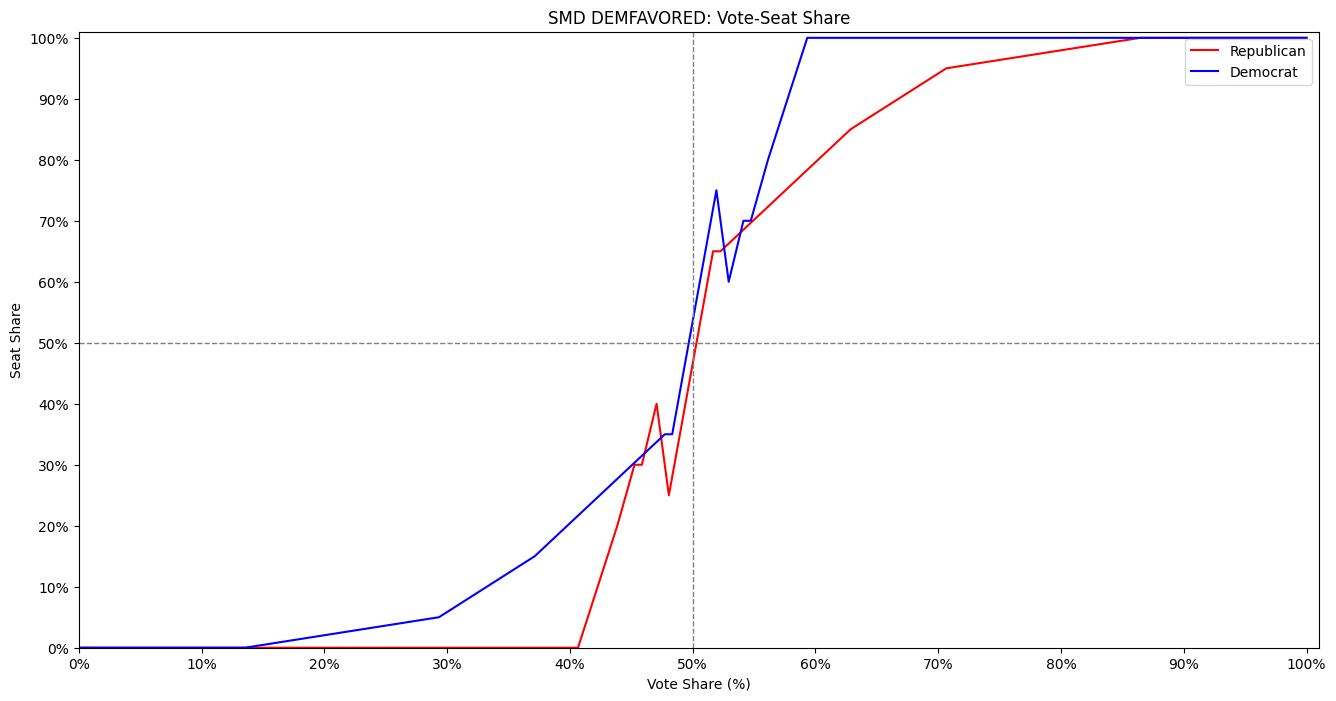

In [321]:


with open('nv_DEMFAVORED.json', 'r') as file:
    data = json.load(file)

random.seed(42)
plt.figure(figsize=(16, 8))

dem_df = pd.DataFrame([[0, 0], [1, 1]], columns = ['x', 'y'])
rep_df = pd.DataFrame([[0, 0], [1, 1]], columns = ['x', 'y'])

simulation = pd.DataFrame(data['curveData'])

total_dem_vote_share = (simulation['totalVotes'] * simulation['demVoteShare']).sum() / simulation['totalVotes'].sum()
total_dem_seat_share = (simulation['demVoteShare'] > 0.5).sum() / len(simulation)

dem_df.loc[len(dem_df)] = [total_dem_vote_share, total_dem_seat_share]
rep_df.loc[len(rep_df)] = [1 - total_dem_vote_share, 1 - total_dem_seat_share]

#simulation2 = simulation.copy()
# add the increment to dem vote share across districts
for i in range(50):
    dem_vote_share = simulation['demVoteShare']
    rep_vote_share = simulation['repVoteShare']
    totalVotes = simulation['totalVotes']

    dem_vote_shares = []
    dem_seat_shares = []
    increments = []
    for j in range(5):
        increment = 0.01 + random.randint(-5, 5) / 100
        increments.append(increment)

        tem_dem_vote_share = dem_vote_share
        tem_dem_vote_share += increment
        tem_dem_vote_share = np.clip(tem_dem_vote_share, 0, 1)

        dem_vote_shares.append((totalVotes * tem_dem_vote_share).sum() / totalVotes.sum())
        dem_seat_shares.append((tem_dem_vote_share > 0.5).sum() / len(simulation))
        
    avg_dem_vote_share = np.average(dem_vote_shares)
    avg_dem_seat_share = np.average(dem_seat_shares)

    simulation['demVoteShare'] += np.average(increments)
    simulation['repVoteShare'] -= np.average(increments)

    dem_df.loc[len(dem_df)] = [avg_dem_vote_share, avg_dem_seat_share]
    rep_df.loc[len(rep_df)] = [1 - avg_dem_vote_share, 1 - avg_dem_seat_share]


for i in range(50):
    dem_vote_share = simulation['demVoteShare']
    rep_vote_share = simulation['repVoteShare']
    totalVotes = simulation['totalVotes']

    dem_vote_shares = []
    dem_seat_shares = []
    increments = []
    for j in range(5):
        increment = -0.01 + random.randint(-5, 5) / 100
        increments.append(increment)

        tem_dem_vote_share = dem_vote_share
        tem_dem_vote_share += increment
        tem_dem_vote_share = np.clip(tem_dem_vote_share, 0, 1)

        dem_vote_shares.append((totalVotes * tem_dem_vote_share).sum() / totalVotes.sum())
        dem_seat_shares.append((tem_dem_vote_share > 0.5).sum() / len(simulation))
        
    avg_dem_vote_share = np.average(dem_vote_shares)
    avg_dem_seat_share = np.average(dem_seat_shares)

    simulation['demVoteShare'] += np.average(increments)
    simulation['repVoteShare'] -= np.average(increments)

    dem_df.loc[len(dem_df)] = [avg_dem_vote_share, avg_dem_seat_share]
    rep_df.loc[len(rep_df)] = [1 - avg_dem_vote_share, 1 - avg_dem_seat_share]

dem_df = dem_df.sort_values(by = 'x')
rep_df = rep_df.sort_values(by = 'x')

plt.plot(rep_df['x'], rep_df['y'], label = 'Republican', color = 'red')
plt.plot(dem_df['x'], dem_df['y'], label = 'Democrat', color = 'blue')

# Set the axis limits
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)

# Set the ticks to show percentages
tick_positions = np.arange(0, 1.1, 0.1)  # Positions for ticks (0% to 100%)
tick_labels = [f"{int(tick * 100)}%" for tick in tick_positions]  # Labels as percentages

plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)

# Labels and legend
plt.title(f'SMD {data["characteristic"]}: Vote-Seat Share')
plt.xlabel("Vote Share (%)")
plt.ylabel("Seat Share")
plt.legend()
plt.show()

In [28]:
#fix box and whisker
def collect_box_and_whisker_bins(data, json, races):

    total_bins = data["totalDistricts"]  # Total bins = total districts per plan

    # Initialize bins to hold percentages
    bins_dict = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}
    enacted_bins = {f"Bin {i+1}": {race: [] for race in races} for i in range(total_bins)}

    # Step 1: Process each district plan
    for plan_index, plan in enumerate(data["barData"]):  
        # Step 2: Extract and sort race percentages within each district plan
        race_percentages = {race: [] for race in races}
        for district in plan["districts"]:  
            total_population = sum(district[race] for race in races)
            for race in races:
                percentage = (district[race] / total_population) * 100 if total_population > 0 else 0
                race_percentages[race].append(percentage)
        
        # Sort percentages for each race and distribute them into bins
        for race in races:
            sorted_percentages = sorted(race_percentages[race])
            for i, value in enumerate(sorted_percentages):
                bin_key = f"Bin {i + 1}"
                bins_dict[bin_key][race].append(value)
        
        # Step 3: Process enacted plan separately (first plan only)
        if plan_index == 0:  
            for race in races:
                sorted_enacted = sorted(race_percentages[race])
                for i, value in enumerate(sorted_enacted):
                    bin_key = f"Bin {i + 1}"
                    enacted_bins[bin_key][race].append(value)

    # Step 4: Calculate statistics for each bin
    json["boxes"] = []
    for bin_key, race_data in bins_dict.items():
        stats = {"bin": bin_key}
        for race, values in race_data.items():
            enacted_values = enacted_bins[bin_key][race]  # Enacted values for this bin and race
            values = np.array(values)
            if len(values) > 0:
                stats[race] = {
                    "min": float(np.min(values)),
                    "q1": float(np.percentile(values, 25)),
                    "median": float(np.median(values)),
                    "q3": float(np.percentile(values, 75)),
                    "max": float(np.max(values)),
                    "enactedValue": round(float(np.mean(enacted_values)), 2) if len(enacted_values) > 0 else 0
                }
            else:
                stats[race] = {"min": 0, "q1": 0, "median": 0, "q3": 0, "max": 0, "enactedValue": 0}
        json["boxes"].append(stats)

nv_box_and_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }
races = ["white", "black", "asian", "hispanic"]
collect_box_and_whisker_bins(nv_demographic_data, nv_box_and_whisker_data, races)
nv_box_and_whisker_data

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': 4,
 'boxes': [{'bin': 'Bin 1',
   'white': {'min': 47.0849166343544,
    'q1': 53.73265912051578,
    'median': 56.07725378704099,
    'q3': 57.99026304350483,
    'max': 62.03081975063709,
    'enactedValue': 56.13},
   'black': {'min': 6.327317145083504,
    'q1': 6.664924953415607,
    'median': 6.695025272328284,
    'q3': 6.932671114684961,
    'max': 8.524623595477674,
    'enactedValue': 6.7},
   'asian': {'min': 8.474122638671327,
    'q1': 9.611312396748826,
    'median': 9.747144918845182,
    'q3': 10.00432379601014,
    'max': 11.770136937152424,
    'enactedValue': 9.75},
   'hispanic': {'min': 1.4416852171542796,
    'q1': 1.5065732834073917,
    'median': 1.519469907148082,
    'q3': 1.5598788475336933,
    'max': 1.8323540791722506,
    'enactedValue': 1.52}},
  {'bin': 'Bin 2',
   'white': {'min': 53.35445224424179,
    'q1': 60.84388165733519,
    'median': 62.179572285305056,
    'q3': 63.392821063537454,
    

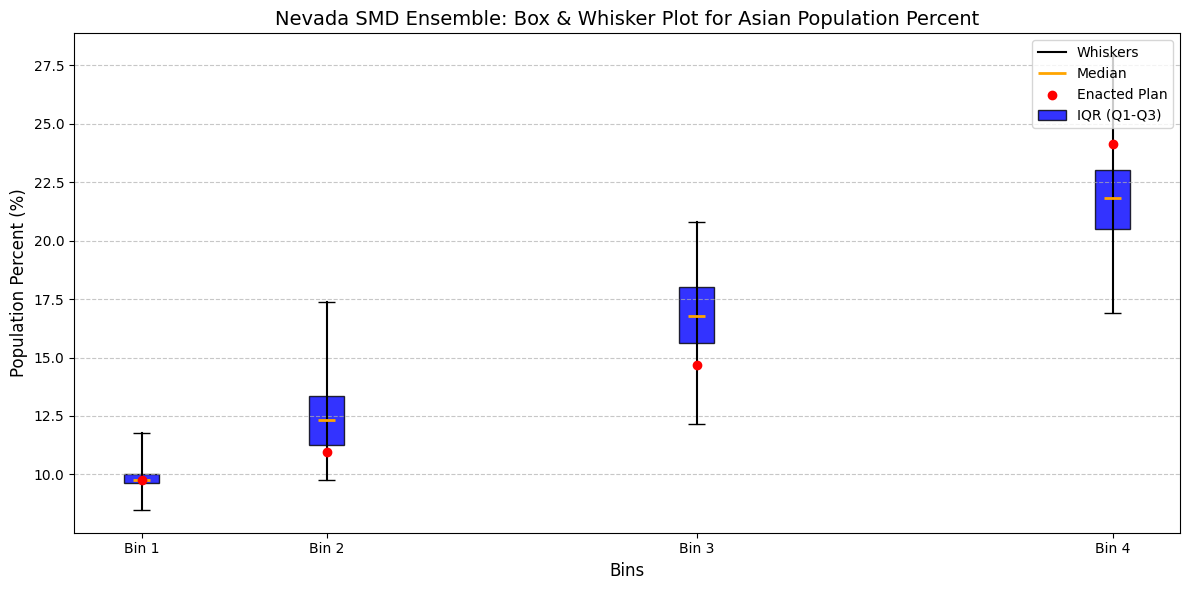

In [35]:
def ensembles_box_and_whisker_plot(data, comparison_basis):
    """
    Constructs a box-and-whisker plot where bins represent sorted percentage ranges for a demographic,
    and each bin starts after the previous max value. Enacted values are added as red dots.

    Args:
        data (dict): Input data containing box statistics and binned data.
        comparison_basis (str): Demographic basis to analyze (e.g., "white", "hispanic").
    """
    # Extract bins and their statistics for the selected comparison_basis
    sorted_boxes = data["boxes"]  # No need to sort explicitly since bins are sequential
    bins = [box["bin"] for box in sorted_boxes]  # Bin labels

    # Extract statistics
    min_values = [box[comparison_basis]["min"] for box in sorted_boxes]
    q1_values = [box[comparison_basis]["q1"] for box in sorted_boxes]
    median_values = [box[comparison_basis]["median"] for box in sorted_boxes]
    q3_values = [box[comparison_basis]["q3"] for box in sorted_boxes]
    max_values = [box[comparison_basis]["max"] for box in sorted_boxes]
    enacted_values = [box[comparison_basis]["enactedValue"] for box in sorted_boxes]

    # Adjust x-positions so each box starts after the previous box's max
    x_positions = [0]  # Initialize the first box position
    for i in range(1, len(max_values)):
        x_positions.append(x_positions[-1] + max_values[i-1] - min_values[i-1] + 1)  # Add space after the previous max

    # Plot
    plt.figure(figsize=(12, 6))

    for i, (x, min_val, q1, median, q3, max_val, enacted_val) in enumerate(
        zip(x_positions, min_values, q1_values, median_values, q3_values, max_values, enacted_values)
    ):
        # Whiskers
        plt.plot([x, x], [min_val, max_val], color='black', zorder=2, label="Whiskers" if i == 0 else "")
        plt.hlines(min_val, x - 0.2, x + 0.2, color='black', linewidth=1)  # Min line
        plt.hlines(max_val, x - 0.2, x + 0.2, color='black', linewidth=1)  # Max line

        # Box (Q1 to Q3)
        plt.bar(
            x, q3 - q1, bottom=q1, width=0.8, color='blue', alpha=0.8,
            edgecolor='black', zorder=1, label="IQR (Q1-Q3)" if i == 0 else ""
        )

        # Median
        plt.hlines(median, x - 0.2, x + 0.2, color='orange', linewidth=2, label="Median" if i == 0 else "")

        # Enacted Value
        plt.scatter(x, enacted_val, color='red', zorder=3, label="Enacted Plan" if i == 0 else "")

    # Add x-axis labels
    plt.xticks(x_positions, bins, rotation=0)
    # Add title and axis labels
    plt.title(f"Nevada SMD Ensemble: Box & Whisker Plot for {comparison_basis.capitalize()} Population Percent", fontsize=14)
    plt.xlabel("Bins", fontsize=12)
    plt.ylabel("Population Percent (%)", fontsize=12)
    # Add legend
    plt.legend(loc="upper right")
    # Add gridlines for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()
ensembles_box_and_whisker_plot(nv_box_and_whisker_data, 'asian')